In [1]:
from pathlib import Path
import numpy as np
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import random


In [2]:
class SimulateTrial:
    '''Generate physiological signals for 1 trial'''

    duration = 10  # s
    sampling_rate = 50
    cut_off = duration * sampling_rate

    def __init__(
            self,
            # default physiological profile for 1 subject
            ramp_up={
                "heart_rate": 70,
                "heart_rate_std": 2,
                "respiratory_rate": 15,
                "drift": 0.1
            },
            ramp_off={
                "heart_rate": 65,
                "heart_rate_std": 5,
                "respiratory_rate": 12,
                "drift": -0.1
            }):
        self.ramp_up = ramp_up
        self.ramp_off = ramp_off

    # simulate physiological signals using nk2
    def signals(
            self,
            sampling_rate=sampling_rate,
            duration=duration):

        ecg = [
            nk.ecg_simulate(
                duration=duration, sampling_rate=sampling_rate, noise=0.1,
                method="daubechies",
                heart_rate=self.ramp_up["heart_rate"],
                heart_rate_std=self.ramp_up["heart_rate_std"]),
            nk.ecg_simulate(
                duration=duration, sampling_rate=sampling_rate, noise=0.1,
                method="daubechies",
                heart_rate=self.ramp_off["heart_rate"],
                heart_rate_std=self.ramp_off["heart_rate_std"])
        ]
        rsp = [
            nk.rsp_simulate(
                duration=duration, sampling_rate=sampling_rate,
                respiratory_rate=self.ramp_up["respiratory_rate"]),
            nk.rsp_simulate(
                duration=duration, sampling_rate=sampling_rate,
                respiratory_rate=self.ramp_off["respiratory_rate"])
        ]
        scl = [
            nk.eda_process(
                nk.eda_simulate(
                    duration=duration, sampling_rate=sampling_rate, noise=0.1,
                    scr_number=2, drift=self.ramp_up["drift"]),
                sampling_rate=sampling_rate)[0]["EDA_Tonic"],
            nk.eda_process(
                nk.eda_simulate(
                    duration=duration, sampling_rate=sampling_rate, noise=0.1,
                    scr_number=2, drift=self.ramp_off["drift"]),
                sampling_rate=sampling_rate)[0]["EDA_Tonic"]
        ]
        # output shape is [trials (up,off), time steps, features]
        data = np.stack([ecg, rsp, scl], axis=2)

        return data


In [3]:
class SimulateSubject:
    '''Generate a physiological profile for 1 subject'''

    def __init__(self, seed):
        # 1 seed for 1 subject
        self.seed = seed
        self.ramp_up, self.ramp_off = self.physio()

    def physio(self):

        np.random.seed(self.seed)
        random.seed(self.seed)

        ramp_up = {
            "heart_rate": random.choice(range(68, 71)),
            "heart_rate_std": random.choice(range(2, 7)),
            "respiratory_rate": random.choice(range(12, 15)),
            "drift": random.choice(range(0, 2))/10
        }
        ramp_off = {
            "heart_rate": random.choice(range(66, 69)),
            "heart_rate_std": random.choice(range(4, 9)),
            "respiratory_rate": random.choice(range(12, 15)),
            "drift": -random.choice(range(0, 2))/10
        }

        return ramp_up, ramp_off


In [4]:
class SimulateExperiment(SimulateSubject, SimulateTrial):
    '''Generate experimental data over several trials using 
    disctinct physiological profiles'''

    def __init__(
            self,
            n_subjects=4,
            n_trials=3):

        self.n_subjects = n_subjects
        self.n_trials = n_trials
        self.n_subject_samples = n_trials*2  # ramp up & off
        self.n_samples = n_subjects*self.n_subject_samples

        self.data = self.simulate_data()
        self.target = self.simulate_target()
        self.groups = np.repeat(np.arange(0, n_subjects), n_trials*2)

    def simulate_data(self):
        data = []

        for i in range(self.n_subjects):
            ramp_up = SimulateSubject(i).ramp_up
            ramp_off = SimulateSubject(i).ramp_off

            data_subject = []

            for j in range(self.n_trials):
                temp = SimulateTrial(ramp_up=ramp_up,
                                     ramp_off=ramp_off).signals()
                data_subject.append(temp)

            data.append(data_subject)

        # in the following we reduce the dimensions of the simulated data
        data = np.array(data)
        # reshape without extra dimension for ramp up & off
        data = np.reshape(data, (
            self.n_subjects,
            self.n_subject_samples,
            data.shape[-2],
            data.shape[-1]
        ))
        # reshape without extra dimension for subject & subject_sample
        # returns [samples, time-steps, features]
        data = np.reshape(data, (
            self.n_samples,
            data.shape[-2],
            data.shape[-1]
        ))

        return data

    def simulate_target(self):
        target = np.empty([self.n_subjects, self.n_subject_samples])

        for i in range(self.n_subjects):
            target[i, ::2] = 0
            target[i, 1::2] = 1

        # reshape without extra dimension for subject & subject_sample
        target = np.reshape(target, (self.n_samples))

        return target


In [5]:
# Create simulated data
n_subjects_train = 100
n_subjects_test = 20
n_subjects = n_subjects_train + n_subjects_test
n_trials = 20

experiment = SimulateExperiment(n_subjects=n_subjects, n_trials=n_trials)

data = experiment.data[:n_subjects_train*n_trials*2]
target = experiment.target[:n_subjects_train*n_trials*2]
groups = experiment.groups[:n_subjects_train*n_trials*2]

data_test = experiment.data[n_subjects_train*n_trials*2:]
target_test = experiment.target[n_subjects_train*n_trials*2:]

print(f"{data.shape = }\n{target.shape = }\n{groups.shape = }\n\n{data_test.shape = }\n{target_test.shape =}")

data.shape = (4000, 500, 3)
target.shape = (4000,)
groups.shape = (4000,)
data_test.shape = (800, 500, 3)
target_test.shape =(800,)


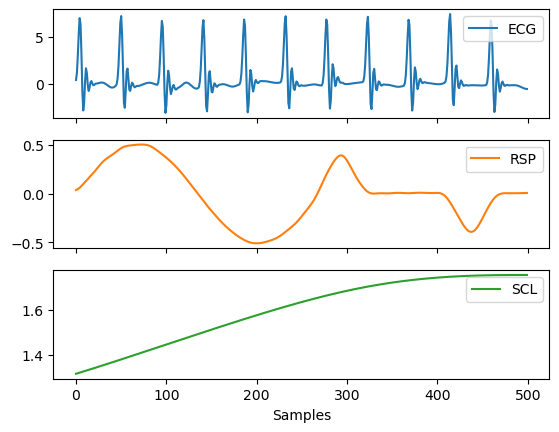

In [6]:
# Visualise 1 trial
trial = 190
data_plot = pd.DataFrame({
    "ECG": data[trial, :, 0],
    "RSP": data[trial, :, 1],
    "SCL": data[trial, :, 2]})

nk.signal_plot(data_plot, subplots=True)


In [7]:
# Save data
np.save(Path(r"data/data.npy"), data)
np.save(Path(r"data/target.npy"), target)
np.save(Path(r"data/groups.npy"), groups)

np.save(Path(r"data/data_test.npy"), data_test)
np.save(Path(r"data/target_test.npy"), target_test)
